In [631]:
import h5py
import numpy as np
import math
import glob
import os
import seaborn as sns
import pandas as pd
import openpyxl
import statistics as stat
from scipy import stats
from scipy import ndimage as ndi

from functools import reduce
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.optimize import curve_fit
def hex_2_rgb(hex_color): # Orange color
    rgb_color = tuple(int(hex_color[i:i+2], 16) / 255.0 for i in (1, 3, 5))
    return rgb_color

General Functions

In [632]:
def get_running_total(lst: list) -> list:
    """
    Compute the running total for a list of numbers.
    
    Given a list of numbers, this function returns a new list 
    where each element is the cumulative sum of the elements 
    up to that point in the original list.

    Parameters:
    - lst (list): A list of numbers.

    Returns:
    - list: A list containing the running total.

    Example:
    >>> get_running_total([1, 2, 3, 4])
    [1, 3, 6, 10]
    """

    def accumulator(acc, x):
        if acc:
            return acc + [acc[-1] + x]
        else:
            return [x]
        
    return reduce(accumulator, lst, [])

def make_dict(my_list):
    my_dict = {}
    for i in range(len(my_list)):
        my_dict[my_list[i]] = i
    return my_dict

def fill_missing(Y, kind="linear"):
    """Fills missing values independently along each dimension after the first."""

    # Store initial shape.
    initial_shape = Y.shape

    # Flatten after first dim.
    Y = Y.reshape((initial_shape[0], -1))

    # Interpolate along each slice.
    for i in range(Y.shape[-1]):
        y = Y[:, i]

        # Build interpolant.
        x = np.flatnonzero(~np.isnan(y))
        f = interp1d(x, y[x], kind=kind, fill_value=np.nan, bounds_error=False)

        # Fill missing
        xq = np.flatnonzero(np.isnan(y))
        y[xq] = f(xq)
        
        # Fill leading or trailing NaNs with the nearest non-NaN values
        mask = np.isnan(y)
        y[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), y[~mask])

        # Save slice
        Y[:, i] = y

    # Restore to initial shape.
    Y = Y.reshape(initial_shape)

    return Y

def smooth_diff(node_loc, deriv, win=25, poly=3):
    """
    node_loc is a [frames, 2] array
    
    win defines the window to smooth over
    
    poly defines the order of the polynomial
    to fit with
    
    """
    node_vel = np.zeros_like(node_loc)
    for c in range(node_loc.shape[-1]):
        node_vel[:, c] = savgol_filter(node_loc[:, c], win, poly, deriv)
    if deriv != 0:
        node_vel = np.linalg.norm(node_vel,axis=1)
    return node_vel

class sleap_vid():
    """
    A class for sleap videos initiated by the filename (.h5 only) and the number of mice 
    you annotated. 

    Attributes:
        name: str, path to an .h5 file 
        mice: number of mice in the experiment, also called tracks 
        locations: np.array, a multidimensional array of dimensions
            (frames, nodes, 2 (x/y coordinates), track_no)
        tracks: list of str, names of tracks assigned during sleap annotation
        nodes: list of str, names of nodes assigned during sleap annotation
        track_dict: dict, keys: str, names of tracks, values: int, dimension of location
            associated with that track
        node_dict: dict, keys: str, names of nodes, values: int, dimension of location 
            associated with that node
                
    Methods:
        smooth_locations: smooths locations with a savtisky-golay filter
        node_velocity: calculates and returns the velocity of a given node 
            for all tracks
        distance_between_mice: calculates and returns distances between tracks
            given a node
        distances_between_nodes: calculates and returns distances between nodes within 
            one skeleton for all tracks
        distances_to_point: calculates and returns distances between a point (x,y coordinates) 
            and a node for each track
        node_angles: calculates and returns the angle between three nodes for each track
        point_angles: calculates and returns the angle between a point and two nodes for
            each track
        orientation: calculates and returns the orientation of the two tracks to each other
        create_events_array: TBD
    """

    def __init__(self, filename, track_no):
        """
        Initiates a sleap_vid class instance 
        Args (2)
            filename: str, path to .h5 file 
            track_no: int, number of mice that you annotated for
        
        Returns: 
            a sleap_vid class instance 
        """
        self.name = filename
        self.mice = track_no
        self.__get_info__(filename)

    def __get_info__(self, filename):
        """
        Opens the .h5 file and reads in the relevant information: interpolates 
        missing location values using np.interp (code taken from sleap.ai)
        saves locations as self.locations, saves track names as self.tracks,
        saves node names as self.nodes, and creates a track_dict and a node_dict
        to map string names to their relevant dimenions in locations
        """
        with h5py.File(filename, "r") as f:
            tracks= [n.decode() for n in f["track_names"][:]]
            locations = f["tracks"][:].T
            locations = locations[:,:,:,:self.mice]
            self.locations = fill_missing(locations)
            nodes = [n.decode() for n in f["node_names"][:]]
            self.tracks = tracks
            self.nodes = nodes
            self.track_dict = make_dict(tracks)
            self.node_dict = make_dict(nodes)

    def smooth_locations(self, win=25, poly=3):
        """
        Smooths locations using a savitsky-golay filter (fxn from numpy, code from
        sleap.ai) and reassigns self.locations to the smoothed locations

        Args (0 required, 2 total):
            win: int, length of filter window
            poly: int, the order of the polynomial used to fit the samples

        Returns:
            none
        """
        for node in self.node_dict.values():
            for track in range(self.mice):
                nodeloc = self.locations[:,node,:,track]
                smoothed_node = smooth_diff(nodeloc, deriv=0, win=win, poly=poly)
                self.locations[:,node,:,track] = smoothed_node
        

    def node_velocity(self, node, num_mice=2, win=25, poly=3, normalization_factor=None):
        """
        takes in node and returns the velocity of that node 
        for each mouse

        Args: 
            node: string, name of node
        
        Returns:
            velocities: 2d np.array of floats (d = 2 x #of frames)
                where each element is the velocity for that node
                distances[0] = velocities for mouse2
                distances[1] = velocities for mouse2
        """
        if num_mice == 2:
            node_loc1 = self.locations[:, self.node_dict[node], :, 0]
            node_loc2 = self.locations[:, self.node_dict[node], :, 1]
            if normalization_factor != None:
                node_loc1 = node_loc1 * normalization_factor
                node_loc2 = node_loc2 * normalization_factor
            m1_vel = smooth_diff(node_loc1, deriv = 1, win=win, poly=poly)
            m2_vel = smooth_diff(node_loc2, deriv = 1, win=win, poly=poly)
            velocities = np.array([m1_vel,m2_vel])
        else: 
            node_loc1 = self.locations[:, self.node_dict[node], :, 0]
            if normalization_factor != None:
                node_loc1 = node_loc1 * normalization_factor
                node_loc2 = node_loc2 * normalization_factor
            m1_vel = smooth_diff(node_loc1, deriv = 1, win=win, poly=poly)
            velocities = np.array(m1_vel)
        return velocities 
    
   
    def distances_between_mice(self, node, normalization_factor=None):
        """
        takes in node name
        returns a list of distances between the nodes of the two mice

        Args:
            node: string, name of node
        Returns:
            c_list: 1D np.array of floats (d = # of frames)
        """
        locations = self.locations 
        node_index = self.node_dict[node]
        x1 = locations[:,node_index,0,0]
        y1 = locations[:,node_index,1,0]
        # x , y coordinate of nose for mouse 1
        x2 = locations[:,node_index,0,1]
        y2 =  locations[:,node_index,1,1]
        # x and y coordinate of nose of mouse 2
        # solve for c using pythagroean theory
        distances = np.sqrt(((x1 - x2)**2) + ((y1 - y2)**2))
        if normalization_factor != None: 
            distances = distances * normalization_factor
            distances = distances.T.flatten()
        return distances
    
    def distances_between_nodes(self, node1, node2, normalization_factor = None):
        """
        takes in two nodes and returns the distances between those nodes 
        for each mouse

        Args: 
            node1: string, name of node 1
            node2: string, name of node 2 
        
        Returns:
            distances: 2d np.array of floats (d = 2 x #of frames)
                where each element is the distance between node1 and node2 
                distances[0] = distances for mouse1
                distances[1] = distances for mouse2
        """
        locations = self.locations
        node_index1 = self.node_dict[node1]
        node_index2 = self.node_dict[node2]
        x1,y1 = locations[:, node_index1,0,0], locations[:,node_index1,1,0]
        # x , y coordinate of node 1 for mouse 1
        x2,y2 = locations[:,node_index2,0,0], locations[:,node_index2,1,0]
        # x, y coordiantes of node 2 for mouse 1
        x3, y3 = locations[:,node_index1,0,1], locations[:,node_index1,1,1]
        # x and y coordinate of node 1 of mouse 2
        x4, y4 = locations[:,node_index2,0,1], locations[:,node_index2,1,1]
        # solve for c using pythagroean theory
        c2 = np.sqrt(((x3 -x4)**2)+ ((y3 - y4)**2))
        c1 = np.sqrt(((x1 - x2)**2) + ((y1 - y2)**2))
        if normalization_factor != None:
            c2 = (c2*normalization_factor).T.flatten()
            c1 = (c1*normalization_factor).T.flatten()
        distances = np.array[c1, c2]
        return distances
    
    def distances_to_point(self, node, point, normalization_factor = None):
        # CONFIRMED THAT IT WORKS in terms of doing the math by hand
        """
        takes in two nodes and returns the distances between those nodes 
        for each mouse

        Args: 
            node1: string, name of node 1
            point: tuple or list of two floats,
                x and y coordinate of desired point

        Returns:
            distances: 2d np.array of floats (d = 2 x #of frames)
                where each element is the distance between node and point 
                distances[0] = distances for mouse1
                distances[1] = distances for mouse2
        """
        locations = self.locations
        node_index = self.node_dict[node]
        px, py = point[0], point[1]
        x1,y1 = locations[:, node_index,0,0], locations[:,node_index,1,0]
        # x , y coordinate of node 1 for mouse 1
        # x, y coordiantes of node 2 for mouse 1
        x3, y3 = locations[:,node_index,0,1], locations[:,node_index,1,1]
        # x and y coordinate of node 1 of mouse 2
        px = np.full_like(x1, fill_value=px)
        py = np.full_like(y1, fill_value=py)
        # solve for c using pythagroean theory
        c2 = np.sqrt(((x3 -px)**2)+ ((y3 - py)**2))
        c1 = np.sqrt(((x1 - px)**2) + ((y1 - py)**2))
        if normalization_factor != None:
            c2 = (c2*normalization_factor).T.flatten()
            c1 = (c1*normalization_factor).T.flatten()
        distances = np.array([c1, c2])
        return distances


    def node_angles(self, node1, node2, node3):
        """
        takes in locations and three nodes, calculates angle between the three points 
        with the second node being the center point
        
        Args:  
            node1: string, name of node 1
            node2: string, name of node 2 
            node3: string, name of node 3

        Returns:
            ang: 2d np. array (d = 2 x # of frames)
                where each element is the angle between 
                node1 and node3 with node2 as center point 
                anles_all_mice[0] = angles for mouse1
                anles_all_mice[1] = angles for mouse2
        """
        locations = self.locations  
        node_index_1 = self.node_dict[node1]
        node_index_2 = self.node_dict[node2]
        node_index_3 = self.node_dict[node3]
        ax = locations[:,node_index_1, 0, :]
        ay = locations[:,node_index_1, 1, :]
        bx = locations[:,node_index_2, 0, :]
        by = locations[:,node_index_2, 1, :]
        cx = locations[:,node_index_3,0,:]
        cy = locations[:,node_index_3, 1, :]
        ang = np.arctan2(cy-by, cx-bx) - np.arctan2(ay-by, ax-bx) 
        ang_swapped = np.arctan2(cy-by, cx-bx) - np.arctan2(cy-by, cx-bx) 
        ang = np.maximum(ang, ang_swapped)
        return ang.T
    
    def point_angles(self, node1, node2, point):
        """
        takes in locations and three nodes, calculates angle between the three points 
        with the second node being the center point
        
        Args:  
            node1: string, name of node 1
            node2: string, name of node 2 
            point: tuple or list of two floats,
                x and y coordinate of desired point

        Returns:
            ang: 2d np. array (d = 2 x # of frames)
                where each element is the angle between 
                node1 and point with node2 as center point 
                anles_all_mice[0] = angles for mouse1
                anles_all_mice[1] = angles for mouse2
        """
        locations = self.locations  
        node_index_1 = self.node_dict[node1]
        node_index_2 = self.node_dict[node2]
        px, py = point[0], point[1]
        ax = locations[:,node_index_1, 0, :]
        ay = locations[:,node_index_1, 1, :]
        bx = locations[:,node_index_2, 0, :]
        by = locations[:,node_index_2, 1, :]
        px = np.full_like(ax, fill_value=px)
        py = np.full_like(ay, fill_value=py)
        ang = np.arctan2(py-by, px-bx) - np.arctan2(ay-by, ax-bx) 
        ang_swapped = np.arctan2(ay-by, ax-bx) - np.arctan2(py-by, px-bx) 
        ang = np.maximum(ang, ang_swapped)
        return ang.T

    def orientation(self):
        """
        Takes in locations and nose and thorax node index to calculate the angle of orientation
        between mice where two mice facing each other results in pi
        theta = 0 means they are not facing each other 
        
        """
        locations = self.locations
        nose_node = self.node_dict['nose']
        thorax_node = self.node_dict['thorax']
        forehead = self.node_dict['forehead']
        ax = locations[:, nose_node, 0, 0]
        ay = locations[:, nose_node, 1, 0]
        bx = locations[:,thorax_node, 0, 0]
        by = locations[:,thorax_node, 1, 0]
        cx = locations[:, forehead, 0, 1]
        cy = locations[:,forehead, 1, 1]
        ang_m1 = np.arctan2(cy-by, cx-bx) - np.arctan2(ay-by, ax-bx) 
        ang_m1_swapped = np.arctan2(ay-by, ax-bx) - np.arctan2(cy-by, cx-bx)
        ax = locations[:, nose_node, 0, 1]
        ay = locations[:, nose_node, 1, 1]
        bx = locations[:,thorax_node, 0, 1]
        by = locations[:,thorax_node, 1, 1]
        cx = locations[:, forehead, 0, 0]
        cy = locations[:,forehead, 1, 0]
        ang_m2 = np.arctan2(cy-by, cx-bx) - np.arctan2(ay-by, ax-bx) 
        ang_m2_swapped = np.arctan2(ay-by, ax-bx) - np.arctan2(cy-by, cx-bx) 
        ang_m1 = np.maximum(ang_m1,ang_m1_swapped)
        ang_m2 = np.maximum(ang_m2,ang_m2_swapped)
        return np.array([ang_m1, ang_m2])
    
    def create_events_array(thresh, feature, greater_than = False, frame_rate = 30):
        """
        This function will create a 2D array of start and stop times (ms) for which 
        a given feature passes a given threshold. The output is an array of two
        element arrays, where the first value is the start time and the second 
        value is the stop time. 

        Args (4 total, 2 required):
            thresh: float, threshold value to filter frames
            feature: 1D numpy array, values of some feature for each frame
            greater_than: Bool, default = False, True if finding frames where feature >= thresh, False for <=
            frame-rate: int, default = 30 fps, frame rate in frames per second

        Return (1):
            output: 2D numpy array, Pairs of start and stop frames for which the value of the feature agrees with your filter    
        """

        #{feature_name: [x,y]} x -> greater than y -> less than 
        if greater_than:
            ind1 = feature.index[feature >= thresh].tolist()
        else:
            ind1 = feature.index[feature <= thresh].tolist()
        start = []
        start.append(ind1[0])

        end = []

        for i in range(len(ind1)-1):
            if (ind1[i]-ind1[i-1])>3:
                start.append(ind1[i])
            
            if (ind1[i+1]-ind1[i])>3:
                end.append(ind1[i])

        end.append(ind1[-1])

        output = np.column_stack((start/frame_rate*1000, end/frame_rate*1000))
        return output

In [633]:
def stamp_to_sec(stamp):
    """
    stamp is time stamp in video, str, in form 'minutes:seconds'
    returns seconds in int
    """ 
    temp = stamp.split(":")
    minutes = int(temp[0])
    seconds = int(temp[1])
    s = seconds + (minutes*60)
    return s

In [634]:
def sec_to_frame(sec, fps=30):
    '''
    sec is seconds; int
    fps is frames per second; int

    returns last frame that this second includes; int
    '''
    frame = sec*fps
    return frame

In [635]:
def stamp_to_frame(stamp, fps=30):
    """
    stamp is 'minutes:seconds'; str
    fps int

    returns last frame included in that time stamp for a video of fps; int
    """
    s = stamp_to_sec(stamp)
    return sec_to_frame(s,fps)

In [636]:
def stamprange_to_frame(stamp_range, fps=30):
    """ 
    stamp_range is a time stamp range in form "minutes:seconds-minutes:seconds"; str
    fps is fps of recording; int

    returns range of frames in list [start frame,end frame]; two element list with integer values
    """
    temp = stamp_range.split("-")
    f1 = stamp_to_frame(temp[0],fps)
    f2 = stamp_to_frame(temp[1],fps)
    range = [f1,f2]
    return range

In [637]:
def get_vel_for_sa(exdict, social_agent, velocities, fps=30, stamp_str=True):
    """ 
    exdict is the dictionary extracted from the excel file with experimental details; dict (nested)
    social_agent is the social agent in interaction as listed in excel sheet; str
    velocities is dictionary of velocities from h5 files with 'file':array of velocities; dict
    fps is the frames per second of the recording; int
    stamp_str tels whether the time stamps given in the dictionaries are single string (True) or arrays (False); boolean

    returns all velocites of subject during bouts with the given social agent; numpy array
    """
    if stamp_str:
        stamps_dict = exdict[social_agent]
        vel_arr = []
        for x in stamps_dict:
            try:
                if stamps_dict[x] == 'empty':
                    temp_range = np.arange(108000,108001,1)
                else:
                    temp_frames = stamprange_to_frame(str(stamps_dict[x]),fps)
                    temp_range = np.arange(temp_frames[0],temp_frames[1],1)
            except:
                print("Time stamp format error: " + str(stamps_dict[x]))
                break
            try:
                temp_vel = velocities[x]
            except:
                print("video name error: " + x)
                break
            for i in temp_range:
                try:
                    #print(temp_vel[i])
                    vel_arr.append(temp_vel[i])    
                except:
                    pass
    else:
        stamps_dict = exdict[social_agent]
        vel_arr = []
        
        for x in stamps_dict:
            try:
                temp_vel = velocities[x]
            except:
                print("video name error: " + x)
                break
            for i in stamps_dict[x]:
                try:
                    #print(temp_vel[i])
                    vel_arr.append(temp_vel[i])    
                except:
                    pass

    
    return np.array(vel_arr)

In [638]:
def get_avg_vel(exdict, social_agent, velocities, fps=30, stamp_str=True):
    """ 
    exdict is the dictionary extracted from the excel file with experimental details; dict (nested)
    social_agent is the social agent in interaction as listed in excel sheet; str
    velocities is dictionary of velocities from h5 files with 'file':array of velocities; dict
    fps is the frames per second of the recording; int
    stamp_str tels whether the time stamps given in the dictionaries are single string (True) or arrays (False); boolean

    returns avg velocites for each bout with given social agent; np array
    """
    if stamp_str:
        stamps_dict = exdict[social_agent]
        vel_arr = []
        for x in stamps_dict:
            temp_arr = []
            try:
                if stamps_dict[x] == 'empty':
                    temp_range = np.arange(108000,108001,1)
                else:
                    temp_frames = stamprange_to_frame(str(stamps_dict[x]),fps)
                    temp_range = np.arange(temp_frames[0],temp_frames[1],1)
            except:
                print("Time stamp format error: " + str(stamps_dict[x]))
                break
            try:
                temp_vel = velocities[x]
            except:
                print("video name error: " + x)
                break
            for i in temp_range:
                try:
                    #print(temp_vel[i])
                    temp_arr.append(temp_vel[i])    

                except:
                    pass
            vel_arr.append(np.mean(np.array(temp_arr)))
    else:
        stamps_dict = exdict[social_agent]
        vel_arr = []
        
        for x in stamps_dict:
            temp_arr = [] 
            try:
                temp_vel = velocities[x]
            except:
                print("video name error: " + x)
                break
            for i in temp_range:
                try:
                    #print(temp_vel[i])
                    temp_arr.append(temp_vel[i])    
                except:
                    pass
            vel_arr.append(np.mean(np.array(temp_arr)))
        
    return np.array(vel_arr)

In [639]:
video_df = pd.read_excel('ephys_socialmem_vidinfo.xlsx','Phase 2')

In [640]:
video_df.head()

,Name of Recording,subject,Familiarization Trial,Mouse taken out,ITI,Social Type 1,Mouse put in,Social 1,Social Type 2,Mouse taken out/put in,Social 2,Social Type 3,Social 3
0,20230803_101331_1.1converted.analysis.h5,1.1,0:06-9:59,9:59-10:03,10:03-13:41,Familiar,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20230803 101331 1.2_converted.analysis.h5,1.1,NaN,NaN,0:00-6:14,Familiar,6:14-6:17,6:17-11:11,Cagemate,11:11-11:17,11:17-16:10,Novel,16:16-60:00
2,20230803 121318 1.1_converted.analysis.h5,1.4,0:05-9:59,9:59-10:04,10:04-17:01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,20230803_121318_1.2_corrected.analysis.h5,1.4,NaN,NaN,0:00-0:50,Novel,0:50-0:53,0:53-5:47,Familiar,5:47-5:54,5:54-10:50,Cagemate,10:56-60:00
4,20230804_141009_1.1_converted.analysis.h5,1.2,0:08-10:00,10:00-10:06,10:06-19:59,Novel,20:00-20:02,20:02-25:00,Familiar,25:00-25:08,25:08-30:00,Cagemate,30:06-60:00


In [641]:
video_df['Name of Recording']=video_df['Name of Recording'].apply(lambda x: 'h5_files/'+ x)
video_df=video_df.fillna("empty")

In [642]:
social_agents = set(video_df['Social Type 1'])

In [643]:
exdict = {}
exdict["ITI"] = {}
for x in social_agents:
    exdict[x]={}
    

In [644]:
for index, row in video_df.iterrows():
    exdict[row['Social Type 1']][row['Name of Recording']]=row['Social 1']
    exdict[row['Social Type 2']][row['Name of Recording']]=row['Social 2']
    exdict[row['Social Type 3']][row['Name of Recording']]=row['Social 3']
    exdict["ITI"][row["Name of Recording"]]=row['ITI']
    

In [645]:
exdict

{'ITI': {'h5_files/20230803_101331_1.1converted.analysis.h5': '10:03-13:41',
  'h5_files/20230803 101331 1.2_converted.analysis.h5': '0:00-6:14',
  'h5_files/20230803 121318 1.1_converted.analysis.h5': '10:04-17:01',
  'h5_files/20230803_121318_1.2_corrected.analysis.h5': '0:00-0:50',
  'h5_files/20230804_141009_1.1_converted.analysis.h5': '10:06-19:59',
  'h5_files/20230817 113746 1.1_converted.analysis.h5': '10:04-20:00',
  'h5_files/20230818 115728 1.1_converted.analysis.h5': 'empty',
  'h5_files/20230818 115728 1.2_converted.analysis.h5': '8:53-19:07',
  'h5_files/20230803 141047 1.1_converted.analysis.h5': '10:05-20:00',
  'h5_files/20230804_121600_1.1_converted.analysis.h5': '10:07-20:03',
  'h5_files/20230818 133620 1.1_converted.analysis.h5': '10:05-19:58',
  'h5_files/20230817_100823_1.1_converted.analysis.h5': '10:33-20:26'},
 'Cagemate': {'h5_files/20230803 101331 1.2_converted.analysis.h5': '11:17-16:10',
  'h5_files/20230803_121318_1.2_corrected.analysis.h5': '10:56-60:00'

In [646]:
exdict["ITI"]={key:val for key, val in exdict["ITI"].items() if val != "empty"}
for x in social_agents:
    exdict[x]={key:val for key, val in exdict[x].items() if val != 'empty'}

In [647]:
exdict

{'ITI': {'h5_files/20230803_101331_1.1converted.analysis.h5': '10:03-13:41',
  'h5_files/20230803 101331 1.2_converted.analysis.h5': '0:00-6:14',
  'h5_files/20230803 121318 1.1_converted.analysis.h5': '10:04-17:01',
  'h5_files/20230803_121318_1.2_corrected.analysis.h5': '0:00-0:50',
  'h5_files/20230804_141009_1.1_converted.analysis.h5': '10:06-19:59',
  'h5_files/20230817 113746 1.1_converted.analysis.h5': '10:04-20:00',
  'h5_files/20230818 115728 1.2_converted.analysis.h5': '8:53-19:07',
  'h5_files/20230803 141047 1.1_converted.analysis.h5': '10:05-20:00',
  'h5_files/20230804_121600_1.1_converted.analysis.h5': '10:07-20:03',
  'h5_files/20230818 133620 1.1_converted.analysis.h5': '10:05-19:58',
  'h5_files/20230817_100823_1.1_converted.analysis.h5': '10:33-20:26'},
 'Cagemate': {'h5_files/20230803 101331 1.2_converted.analysis.h5': '11:17-16:10',
  'h5_files/20230803_121318_1.2_corrected.analysis.h5': '10:56-60:00',
  'h5_files/20230804_141009_1.1_converted.analysis.h5': '30:06-

Now to velocites dict:

In [648]:
filenames = os.listdir('h5_files/')
print(filenames)


['20230803 101331 1.2_converted.analysis.h5', '20230803 121318 1.1_converted.analysis.h5', '20230803 141047 1.1_converted.analysis.h5', '20230803_101331_1.1converted.analysis.h5', '20230803_121318_1.2_corrected.analysis.h5', '20230804_121600_1.1_converted.analysis.h5', '20230804_141009_1.1_converted.analysis.h5', '20230817 113746 1.1_converted.analysis.h5', '20230817_100823_1.1_converted.analysis.h5', '20230818 115728 1.1_converted.analysis.h5', '20230818 115728 1.2_converted.analysis.h5', '20230818 133620 1.1_converted.analysis.h5']


In [649]:
h5_list = []
for x in filenames:
    print('h5_files/'+x)
    h5_list.append(sleap_vid('h5_files/'+ x,2))

h5_files/20230803 101331 1.2_converted.analysis.h5
h5_files/20230803 121318 1.1_converted.analysis.h5
h5_files/20230803 141047 1.1_converted.analysis.h5
h5_files/20230803_101331_1.1converted.analysis.h5
h5_files/20230803_121318_1.2_corrected.analysis.h5
h5_files/20230804_121600_1.1_converted.analysis.h5
h5_files/20230804_141009_1.1_converted.analysis.h5
h5_files/20230817 113746 1.1_converted.analysis.h5
h5_files/20230817_100823_1.1_converted.analysis.h5
h5_files/20230818 115728 1.1_converted.analysis.h5
h5_files/20230818 115728 1.2_converted.analysis.h5
h5_files/20230818 133620 1.1_converted.analysis.h5


In [650]:
num_h5=len(h5_list)
print(h5_list[num_h5-1].name)

h5_files/20230818 133620 1.1_converted.analysis.h5


In [651]:
thor = 'thorax'


In [652]:
subj_velocities = {}
agent_velocities = {}
for x in h5_list:
    x.smooth_locations()
    x.__get_info__(x.name)
    subj_velocities[x.name] = np.nan_to_num(x.node_velocity(thor)[0])
    agent_velocities[x.name] = np.nan_to_num(x.node_velocity(thor)[1])



In [653]:
subj_velocities

{'h5_files/20230803 101331 1.2_converted.analysis.h5': array([0.30042303, 0.209346  , 0.12950578, ..., 1.66439738, 2.01655617,
        2.3875633 ]),
 'h5_files/20230803 121318 1.1_converted.analysis.h5': array([0.20499524, 0.18308842, 0.16253663, ..., 0.29308241, 0.28531213,
        0.27575123]),
 'h5_files/20230803 141047 1.1_converted.analysis.h5': array([3.82144695, 4.28487782, 4.70759894, ..., 0.27692253, 0.35483133,
        0.58818361]),
 'h5_files/20230803_101331_1.1converted.analysis.h5': array([0.6288373 , 0.48900911, 0.36031611, ..., 2.40103379, 2.5832219 ,
        2.79480328]),
 'h5_files/20230803_121318_1.2_corrected.analysis.h5': array([0.54446433, 0.32087649, 0.25568068, ..., 3.11067253, 3.45555249,
        3.84144273]),
 'h5_files/20230804_121600_1.1_converted.analysis.h5': array([0.03423879, 0.02938207, 0.02497569, ..., 3.97602862, 4.78651965,
        5.67986463]),
 'h5_files/20230804_141009_1.1_converted.analysis.h5': array([0.20378482, 0.18820559, 0.17248429, ..., 0.75

In [654]:
ITI_vels = get_avg_vel(exdict, "ITI", subj_velocities)
ITI_vels

array([0.62735195, 0.62752731, 2.19444479, 1.23853342, 0.57567814,
       0.00803158, 0.03595005, 0.71941891, 2.68957133, 0.02620608,
       0.38379512])

In [655]:
fam_vels= get_avg_vel(exdict, "Familiar", subj_velocities)
fam_vels

array([0.83868497, 2.23619795, 0.7793022 , 0.71800571, 1.04996693,
       0.57420779, 3.18227227, 1.49881851, 0.69564598])

In [656]:
novel_vels= get_avg_vel(exdict, "Novel", subj_velocities)
novel_vels

array([0.97359215, 2.53696616, 1.12291046, 2.5456736 , 1.97920948,
       0.59051561, 2.57601037, 1.39744066, 0.77154653])

In [657]:
cm_vels = get_avg_vel(exdict, "Cagemate", subj_velocities)
cm_vels

array([0.96515161, 0.93382535, 0.79156271, 2.50328803, 1.35870194,
       0.73796999, 2.02296119, 1.39458542, 0.6116056 ])

In [658]:
ITI_avg = np.mean(ITI_vels)
fam_avg = np.mean(fam_vels)
nov_avg = np.mean(novel_vels)
cm_avg = np.mean(cm_vels)

print(ITI_avg)
print(fam_avg)
print(nov_avg)
print(cm_avg)


0.8296826066433431
1.2859002552212984
1.610429445522779
1.257739093936112


In [659]:
ITI_std = stats.sem(ITI_vels)
fam_std = stats.sem(fam_vels)
nov_std = stats.sem(novel_vels)
cm_std = stats.sem(cm_vels)


print(ITI_std)
print(fam_std)
print(nov_std)
print(cm_std)


0.26623492119814557
0.2942585983292029
0.26962027444412956
0.21283058609875558


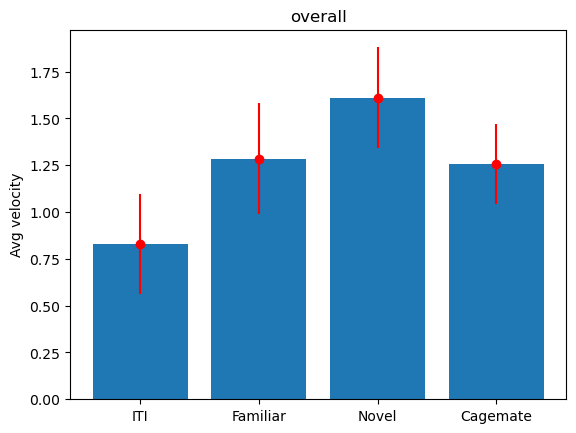

In [660]:
fig, ax = plt.subplots()

agents = ['ITI', 'Familiar', 'Novel', 'Cagemate']
counts = [ITI_avg, fam_avg, nov_avg, cm_avg]
err= [ITI_std,fam_std,nov_std,cm_std]

ax.bar(agents, counts)

ax.set_ylabel('Avg velocity')
ax.set_title("overall")

plt.errorbar(agents, counts, yerr=err, fmt="o", color="r")

plt.show()

Phase 2 by subject

1.1

In [661]:
df_11 = video_df[video_df["subject"] == 1.1]

In [662]:
df_11

,Name of Recording,subject,Familiarization Trial,Mouse taken out,ITI,Social Type 1,Mouse put in,Social 1,Social Type 2,Mouse taken out/put in,Social 2,Social Type 3,Social 3
0,h5_files/20230803_101331_1.1converted.analysis.h5,1.1,0:06-9:59,9:59-10:03,10:03-13:41,Familiar,empty,empty,empty,empty,empty,empty,empty
1,h5_files/20230803 101331 1.2_converted.analysi...,1.1,empty,empty,0:00-6:14,Familiar,6:14-6:17,6:17-11:11,Cagemate,11:11-11:17,11:17-16:10,Novel,16:16-60:00
11,h5_files/20230817_100823_1.1_converted.analysi...,1.1,0:00-10: 30,10:30-10:33,10:33-20:26,Cagemate,20:26-20:28,20:28-25:26,Novel,25:26-25:31,25:31-30:28,Familiar,30:28-60:00


In [663]:
exdict11 = {}
exdict11["ITI"] = {}
for x in social_agents:
    exdict11[x]={}
    

In [664]:
for index, row in df_11.iterrows():
    exdict11[row['Social Type 1']][row['Name of Recording']]=row['Social 1']
    exdict11[row['Social Type 2']][row['Name of Recording']]=row['Social 2']
    exdict11[row['Social Type 3']][row['Name of Recording']]=row['Social 3']
    exdict11["ITI"][row["Name of Recording"]]=row['ITI']

exdict11["ITI"]={key:val for key, val in exdict11["ITI"].items() if val != "empty"}
for x in social_agents:
    exdict11[x]={key:val for key, val in exdict11[x].items() if val != 'empty'}
    

In [665]:
exdict11

{'ITI': {'h5_files/20230803_101331_1.1converted.analysis.h5': '10:03-13:41',
  'h5_files/20230803 101331 1.2_converted.analysis.h5': '0:00-6:14',
  'h5_files/20230817_100823_1.1_converted.analysis.h5': '10:33-20:26'},
 'Cagemate': {'h5_files/20230803 101331 1.2_converted.analysis.h5': '11:17-16:10',
  'h5_files/20230817_100823_1.1_converted.analysis.h5': '20:28-25:26'},
 'Novel': {'h5_files/20230803 101331 1.2_converted.analysis.h5': '16:16-60:00',
  'h5_files/20230817_100823_1.1_converted.analysis.h5': '25:31-30:28'},
 'empty': {},
 'Familiar': {'h5_files/20230803 101331 1.2_converted.analysis.h5': '6:17-11:11',
  'h5_files/20230817_100823_1.1_converted.analysis.h5': '30:28-60:00'}}

In [666]:
ITI11 = get_avg_vel(exdict11, "ITI",subj_velocities)
fam11 = get_avg_vel(exdict11, "Familiar", subj_velocities)
nov11 = get_avg_vel(exdict11, "Novel", subj_velocities)
cm11 = get_avg_vel(exdict11, "Cagemate", subj_velocities)

In [667]:
ITI11a = np.mean(ITI11)
fam11a = np.mean(fam11)
nov11a = np.mean(nov11)
cm11a = np.mean(cm11)

ITI11s = stats.sem(ITI11)
fam11s = stats.sem(fam11)
nov11s = stats.sem(nov11)
cm11s = stats.sem(cm11)

In [668]:
print(ITI11s)

0.0812148511475344


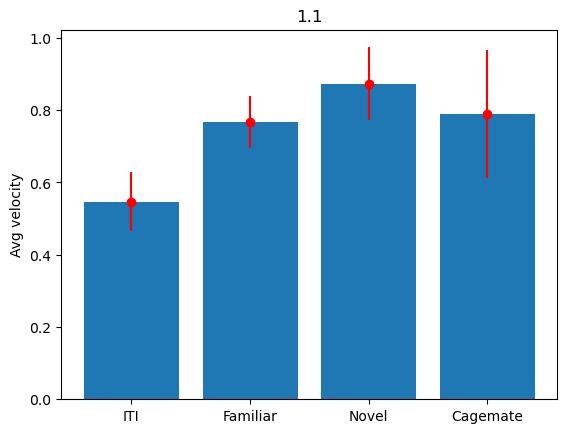

In [669]:
fig, ax = plt.subplots()

agents = ['ITI', 'Familiar', 'Novel', 'Cagemate']
counts = [ITI11a, fam11a, nov11a, cm11a]
err= [ITI11s,fam11s,nov11s,cm11s]

ax.bar(agents, counts)

ax.set_ylabel('Avg velocity')
ax.set_title("1.1")

plt.errorbar(agents, counts, yerr=err, fmt="o", color="r")

plt.show()

1.2

In [670]:
df_12 = video_df[video_df["subject"] == 1.2]

In [671]:
exdict12 = {}
exdict12["ITI"] = {}
for x in social_agents:
    exdict12[x]={}
    

In [672]:
for index, row in df_12.iterrows():
    exdict12[row['Social Type 1']][row['Name of Recording']]=row['Social 1']
    exdict12[row['Social Type 2']][row['Name of Recording']]=row['Social 2']
    exdict12[row['Social Type 3']][row['Name of Recording']]=row['Social 3']
    exdict12["ITI"][row["Name of Recording"]]=row['ITI']

exdict12["ITI"]={key:val for key, val in exdict12["ITI"].items() if val != "empty"}
for x in social_agents:
    exdict12[x]={key:val for key, val in exdict12[x].items() if val != 'empty'}    
    

In [673]:
exdict12

{'ITI': {'h5_files/20230804_141009_1.1_converted.analysis.h5': '10:06-19:59',
  'h5_files/20230817 113746 1.1_converted.analysis.h5': '10:04-20:00',
  'h5_files/20230803 141047 1.1_converted.analysis.h5': '10:05-20:00'},
 'Cagemate': {'h5_files/20230804_141009_1.1_converted.analysis.h5': '30:06-60:00',
  'h5_files/20230817 113746 1.1_converted.analysis.h5': '25:06-30:11',
  'h5_files/20230803 141047 1.1_converted.analysis.h5': '20:03-25:00'},
 'Novel': {'h5_files/20230804_141009_1.1_converted.analysis.h5': '20:02-25:00',
  'h5_files/20230817 113746 1.1_converted.analysis.h5': '30:17-60:00',
  'h5_files/20230803 141047 1.1_converted.analysis.h5': '25:06-30:00'},
 'empty': {},
 'Familiar': {'h5_files/20230804_141009_1.1_converted.analysis.h5': '25:08-30:00',
  'h5_files/20230817 113746 1.1_converted.analysis.h5': '20:03-24:59',
  'h5_files/20230803 141047 1.1_converted.analysis.h5': '30:06-60:00'}}

In [674]:
ITI12 = get_avg_vel(exdict12, "ITI",subj_velocities)
fam12 = get_avg_vel(exdict12, "Familiar", subj_velocities)
nov12 = get_avg_vel(exdict12, "Novel", subj_velocities)
cm12 = get_avg_vel(exdict12, "Cagemate", subj_velocities)

In [675]:
ITI12a = np.mean(ITI12)
fam12a = np.mean(fam12)
nov12a = np.mean(nov12)
cm12a = np.mean(cm12)

ITI12s = stats.sem(ITI12)
fam12s = stats.sem(fam12)
nov12s = stats.sem(nov12)
cm12s = stats.sem(cm12)

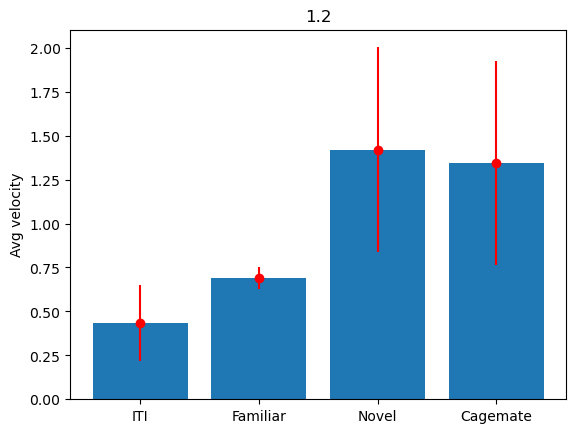

In [676]:
fig, ax = plt.subplots()

agents = ['ITI', 'Familiar', 'Novel', 'Cagemate']
counts = [ITI12a, fam12a, nov12a, cm12a]
err= [ITI12s,fam12s,nov12s,cm12s]

ax.bar(agents, counts)

ax.set_ylabel('Avg velocity')
ax.set_title("1.2")

plt.errorbar(agents, counts, yerr=err, fmt="o", color="r")

plt.show()

1.4

In [677]:
df_14 = video_df[video_df["subject"] == 1.4]

In [678]:
exdict14 = {}
exdict14["ITI"] = {}
for x in social_agents:
    exdict14[x]={}
    
for index, row in df_14.iterrows():
    exdict14[row['Social Type 1']][row['Name of Recording']]=row['Social 1']
    exdict14[row['Social Type 2']][row['Name of Recording']]=row['Social 2']
    exdict14[row['Social Type 3']][row['Name of Recording']]=row['Social 3']
    exdict14["ITI"][row["Name of Recording"]]=row['ITI']

exdict14["ITI"]={key:val for key, val in exdict14["ITI"].items() if val != "empty"}
for x in social_agents:
    exdict14[x]={key:val for key, val in exdict14[x].items() if val != 'empty'}        

ITI14 = get_avg_vel(exdict14, "ITI",subj_velocities)
fam14 = get_avg_vel(exdict14, "Familiar", subj_velocities)
nov14 = get_avg_vel(exdict14, "Novel", subj_velocities)
cm14 = get_avg_vel(exdict14, "Cagemate", subj_velocities)

ITI14a = np.mean(ITI14)
fam14a = np.mean(fam14)
nov14a = np.mean(nov14)
cm14a = np.mean(cm14)

ITI14s = stats.sem(ITI14)
fam14s = stats.sem(fam14)
nov14s = stats.sem(nov14)
cm14s = stats.sem(cm14)

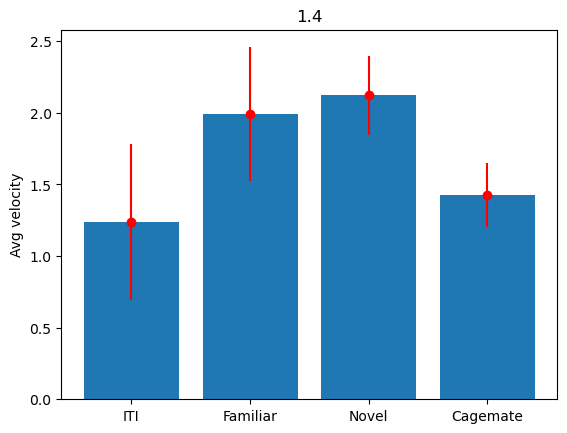

In [679]:
fig, ax = plt.subplots()

agents = ['ITI', 'Familiar', 'Novel', 'Cagemate']
counts = [ITI14a, fam14a, nov14a, cm14a]
err= [ITI14s,fam14s,nov14s,cm14s]

ax.bar(agents, counts)

ax.set_ylabel('Avg velocity')
ax.set_title("1.4")

plt.errorbar(agents, counts, yerr=err, fmt="o", color="r")

plt.show()

2.4

Phase 3

Cup labels

In [680]:
p3_filenames = os.listdir('h5_p3/')
print(filenames)


['20230803 101331 1.2_converted.analysis.h5', '20230803 121318 1.1_converted.analysis.h5', '20230803 141047 1.1_converted.analysis.h5', '20230803_101331_1.1converted.analysis.h5', '20230803_121318_1.2_corrected.analysis.h5', '20230804_121600_1.1_converted.analysis.h5', '20230804_141009_1.1_converted.analysis.h5', '20230817 113746 1.1_converted.analysis.h5', '20230817_100823_1.1_converted.analysis.h5', '20230818 115728 1.1_converted.analysis.h5', '20230818 115728 1.2_converted.analysis.h5', '20230818 133620 1.1_converted.analysis.h5']


In [681]:
h5_p3_list = []
corner_list = []

for x in p3_filenames:
    h5_p3_list.append(sleap_vid("h5_p3/"+x,1))
    corner_list.append(sleap_vid("cup_labels/corners."+x, 4))

print(h5_p3_list)


[<__main__.sleap_vid object at 0x0000027ADA6172F0>, <__main__.sleap_vid object at 0x0000027ADBB16330>, <__main__.sleap_vid object at 0x0000027ADD559040>, <__main__.sleap_vid object at 0x0000027ADA569F10>, <__main__.sleap_vid object at 0x0000027ADAD52F00>, <__main__.sleap_vid object at 0x0000027ADA626B40>, <__main__.sleap_vid object at 0x0000027ADB114410>, <__main__.sleap_vid object at 0x0000027ADBACA6C0>, <__main__.sleap_vid object at 0x0000027ADA61B170>]


In [682]:
for x in corner_list:
    x.__get_info__(x.name)
    print(x.tracks)
    

['cup_1', 'cup_3', 'cup_2', 'cup_4']
['cup_1', 'cup_2', 'cup_3', 'cup_4']
['cup_1', 'cup_2', 'cup_3', 'cup_4']
['cup_1', 'cup_2', 'cup_3', 'cup_4']
['cup_1', 'cup_2', 'cup_3', 'cup_4']
['cup_1', 'cup_2', 'cup_3', 'cup_4']
['cup_1', 'cup_2', 'cup_3', 'cup_4']
['cup_1', 'cup_2', 'cup_3', 'cup_4']
['cup_1', 'cup_2', 'cup_3', 'cup_4']


In [683]:
p3_df = pd.read_excel('ephys_socialmem_vidinfo.xlsx','Phase 3')
p3_df=p3_df.fillna("empty")
p3_df.head()

,Name of Recording,Baseline,Mouse put in,Familiarization,Cup,Mouse taken out,ITI,Mice put in,Cup 1,Cup 2,Cup 3,Cup 4,Familiar,Novel,Cagemate,Empty,Unnamed: 16,Unnamed: 17,Unnamed: 18
0,20230811 101635 1.1_converted.analysis.h5,0:00-10:01,10:01-10:08,10:08-20:08,4.0,20:08-20:21,20:21-30:09,30:09-31:43,Cagemate,Empty,Novel,Familiar,cup_4,cup_3,cup_1,cup_2,done,empty,empty
1,20230809 120416 1.2_converted.analysis.h5,0:00-0:30,0:30-0:44,0:44-10:46,3.0,10:46-11:06,11:06-21:03,21:03-22:56,Empty,Novel,Familiar,Cagemate,cup_3,cup_2,cup_4,cup_1,skip for now,deepnote,IGNORE FOR EPHYS
2,20230809 103121 1.1_converted.analysis.h5,0:00-10:01,10:01-11:15,11:15-20:58,2.0,20:58-21:11,21:11-31:00,31:00-32:19,Novel,Familiar,Cagemate,Empty,cup_2,cup_1,cup_3,cup_4,done,deepnote,empty
3,20230811 120331.1_converted.analysis.h5,0:00-10:11,10:11-10: 28,10:28-20:30,1.0,20:30-20:44,20:44-25:02,empty,empty,empty,empty,empty,empty,empty,empty,empty,skip for now,deepnote,empty
4,20230809 143303 1.1_converted.analysis.h5,0:00-10:02,10:02-10:29,10:29-20:34,2.0,20:34-21:00,21:00-30:56,30:56-32:33,Cagemate,Familiar,Novel,Empty,cup_2,cup_3,cup_1,cup_4,done,deepnote,empty


In [684]:
cups = social_agents
cups.add("Empty")

In [685]:
p3dict = {}
p3dict["ITI"] = {}
for x in social_agents:
    p3dict[x]={}

p3dict

{'ITI': {},
 'Cagemate': {},
 'Empty': {},
 'empty': {},
 'Familiar': {},
 'Novel': {}}

In [686]:
for index, row in p3_df.iterrows():
    p3dict["Familiar"][row['Name of Recording']]=row['Familiar']
    p3dict["Novel"][row['Name of Recording']]=row['Novel']
    p3dict['Cagemate'][row['Name of Recording']]=row['Cagemate']
    p3dict["Empty"][row["Name of Recording"]]=row["Empty"]
    p3dict["ITI"][row["Name of Recording"]]=row['ITI']

p3dict["ITI"]={key:val for key, val in p3dict["ITI"].items() if val != "empty"}
for x in cups:
    p3dict[x]={key:val for key, val in p3dict[x].items() if val != 'empty'}
del p3dict["empty"]
print(p3dict)

{'ITI': {'20230811 101635 1.1_converted.analysis.h5': '20:21-30:09', '20230809 120416 1.2_converted.analysis.h5': '11:06-21:03', '20230809 103121 1.1_converted.analysis.h5': '21:11-31:00', '20230811 120331.1_converted.analysis.h5': '20:44-25:02', '20230809 143303 1.1_converted.analysis.h5': '21:00-30:56', '20230810 120856 1.1_converted.analysis.h5': '23:30-32:30', '20230810 101534 1.1_converted.analysis.h5': '20:20-30:21', '20230810 140909 1.1_converted.analysis.h5': '20:34-30:36', '20230811 154219 1.1_converted.analysis.h5': '20:11-30:37'}, 'Cagemate': {'20230811 101635 1.1_converted.analysis.h5': 'cup_1', '20230809 120416 1.2_converted.analysis.h5': 'cup_4', '20230809 103121 1.1_converted.analysis.h5': 'cup_3', '20230809 143303 1.1_converted.analysis.h5': 'cup_1', '20230810 120856 1.1_converted.analysis.h5': 'cup_1', '20230810 101534 1.1_converted.analysis.h5': 'cup_4', '20230810 140909 1.1_converted.analysis.h5': 'cup_2', '20230811 154219 1.1_converted.analysis.h5': 'cup_3'}, 'Empty

In [687]:
p3_velocities = {}
for x in h5_p3_list:
    x.smooth_locations()
    x.__get_info__(x.name)
    p3_velocities[x.name] = np.nan_to_num(x.node_velocity(thor, num_mice = 1))

p3_velocities


{'h5_p3/20230809 103121 1.1_converted.analysis.h5': array([1.19842838, 1.08358966, 0.97505247, ..., 0.61780149, 0.76666294,
        0.92533532]),
 'h5_p3/20230809 120416 1.2_converted.analysis.h5': array([0.26919752, 0.1912017 , 0.19143952, ..., 0.33492878, 0.49704564,
        0.67191313]),
 'h5_p3/20230809 143303 1.1_converted.analysis.h5': array([9.10698867, 8.17056793, 7.28483244, ..., 3.44846738, 3.17117014,
        2.87444275]),
 'h5_p3/20230810 101534 1.1_converted.analysis.h5': array([3.68665385, 2.59077422, 1.60163805, ..., 0.4027512 , 0.47463376,
        0.55160471]),
 'h5_p3/20230810 120856 1.1_converted.analysis.h5': array([1.51558036, 1.24223198, 0.98975685, ..., 0.16970354, 0.19941186,
        0.23150122]),
 'h5_p3/20230810 140909 1.1_converted.analysis.h5': array([9.04020882, 7.85323812, 6.74905325, ..., 6.85811839, 7.82947394,
        8.9846129 ]),
 'h5_p3/20230811 101635 1.1_converted.analysis.h5': array([4.00979811, 3.53134205, 3.0845435 , ..., 0.30880566, 0.19200454,
